# Hyper-Graph based appraoch

## Modifying the HyperGraphQAModel with Cross-Attention

We will now modify the `HyperGraphQAModel` to incorporate a cross-attention mechanism. This will allow the model to attend to the relationship between the question and context tokens after the hypergraph processing. We'll add a standard Transformer encoder layer with cross-attention.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import re, string
import networkx as nx
import matplotlib.pyplot as plt
import re, string
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, BertModel # Import BertModel
from datasets import load_dataset

# Assuming HyperGCN is defined in a previous cell

class CrossAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_attention_heads=8):
        super().__init__()
        self.cross_attention = nn.MultiheadAttention(hidden_size, num_attention_heads)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, query, key_value, attention_mask=None):
        # query: (B, T_q, H_features) - e.g., context tokens
        # key_value: (B, T_kv, H_features) - e.g., question tokens
        # attention_mask: (B, T_q, T_kv) - mask to prevent attention to padded tokens

        # PyTorch MultiheadAttention expects shape (T, B, H_features)
        query = query.transpose(0, 1)
        key_value = key_value.transpose(0, 1)

        # If attention_mask is provided, it should be (B, T_q, T_kv)
        # For MultiheadAttention, the mask is typically (B, T_q, T_kv) or (T_q, T_kv)
        # Let's assume we are masking padded tokens in key_value
        # Need to create a mask suitable for MultiheadAttention (additive mask)
        # If attention_mask is (B, T_kv), we need to expand it to (B, T_q, T_kv)
        # And invert it (0 for attend, -inf for ignore)
        attn_mask = None
        if attention_mask is not None:
             # Assuming attention_mask is (B, T_kv) for the key_value sequence
             # Create an additive mask: -inf where mask is 0 (padded), 0 elsewhere
             additive_mask = (1 - attention_mask.unsqueeze(1)).bool() # (B, 1, T_kv)
             # MultiheadAttention expects key_padding_mask of shape (B, T_kv)
             # Where True means ignore, False means attend
             key_padding_mask = (attention_mask == 0) # (B, T_kv)
             attn_mask = key_padding_mask


        cross_attn_output, _ = self.cross_attention(
            query,
            key_value,
            key_value, # Value is the same as Key here
            key_padding_mask=attn_mask # Use key_padding_mask
        )

        # Transpose back to (B, T_q, H_features)
        cross_attn_output = cross_attn_output.transpose(0, 1)

        # Add residual connection and layer norm
        output = self.norm(query.transpose(0, 1) + self.dropout(cross_attn_output))


        return output


class HyperGraphQAModelWithCrossAttention(nn.Module):
    def __init__(self, hidden_size=768, alpha=0.1, num_hg_layers=4):
        super().__init__()
        self.encoder = AutoModel.from_pretrained("bert-base-uncased")

        self.hg_layers = nn.ModuleList([
            HyperGCN(hidden_size, hidden_size, alpha) for _ in range(num_hg_layers)
        ])

        self.context_question_attention = CrossAttentionLayer(hidden_size)
        self.question_context_attention = CrossAttentionLayer(hidden_size)


        self.start_head = nn.Linear(hidden_size, 1)
        self.end_head = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids, H_matrix):
        # input_ids: (B, T)
        # attention_mask: (B, T)
        # token_type_ids: (B, T) - 0 for question, 1 for context
        # H_matrix: (B, T, num_hyperedges) or (T, num_hyperedges) - need to handle batching for H_matrix

        # Ensure H_matrix is batched if not already
        if H_matrix.ndim == 2:
            H_matrix = H_matrix.unsqueeze(0).expand(input_ids.size(0), -1, -1) # (B, T, num_hyperedges)


        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        X = outputs.last_hidden_state  # (B, T, H_features)

        # Apply the hypergraph layers sequentially
        X_hg = X
        for hg_layer in self.hg_layers:
            # HyperGCN expects H_matrix of shape (T, num_hyperedges) per example
            # We need to apply HyperGCN to each example in the batch
            # This requires iterating through the batch or using a batched HyperGCN
            # For simplicity here, assuming H_matrix is (B, T, num_hyperedges)
            # Let's adjust HyperGCN to handle batched H_matrix
            # Or, process each example in the batch
            # Let's stick to processing one example at a time for clarity, though less efficient
            # The current HyperGCN expects (T, num_hyperedges) and X (B, T, H_features)
            # The forward pass in HyperGCN needs adjustment for batched H_matrix input

            # Reverting to processing per example for now, assuming batch size is 1
            # If batch size > 1, need to loop or use a different HyperGCN implementation
            if input_ids.size(0) > 1:
                 raise NotImplementedError("Batched HyperGCN not implemented yet")


            # Assuming batch size is 1
            X_hg = hg_layer(X_hg.squeeze(0), H_matrix.squeeze(0)).unsqueeze(0)


        # Separate question and context representations
        question_mask = (token_type_ids == 0) # (B, T)
        context_mask = (token_type_ids == 1)  # (B, T)

        question_h = X_hg[question_mask].view(input_ids.size(0), -1, X_hg.size(-1)) # (B, T_q, H_features)
        context_h = X_hg[context_mask].view(input_ids.size(0), -1, X_hg.size(-1))   # (B, T_c, H_features)

        # Get attention masks for question and context
        question_attention_mask = attention_mask[question_mask].view(input_ids.size(0), -1) # (B, T_q)
        context_attention_mask = attention_mask[context_mask].view(input_ids.size(0), -1)   # (B, T_c)


        # Apply cross-attention
        # Context attends to Question
        context_attended_to_question = self.context_question_attention(
            query=context_h,
            key_value=question_h,
            attention_mask=question_attention_mask # Mask for the key_value sequence (question)
        )

        # Question attends to Context
        question_attended_to_context = self.question_context_attention(
            query=question_h,
            key_value=context_h,
            attention_mask=context_attention_mask # Mask for the key_value sequence (context)
        )


        # Combine the representations (various ways to do this, e.g., concatenation, addition)
        # For simplicity, let's add the attended representations back to the original HG outputs
        # Need to put the attended representations back into the original sequence shape (B, T, H_features)
        combined_h = torch.zeros_like(X_hg)
        # This indexing might be tricky with batching and variable sequence lengths
        # A safer way would be to pad the question/context representations before cross-attention
        # Or, iterate through the batch.
        # Given the complexity with variable lengths and batching, let's simplify
        # Assume for now we only run with batch size 1, or pad appropriately.

        # Simplified combination for batch size 1
        if input_ids.size(0) == 1:
            combined_h[0, question_mask[0]] = question_h[0] + question_attended_to_context[0]
            combined_h[0, context_mask[0]] = context_h[0] + context_attended_to_question[0]
        else:
             raise NotImplementedError("Combination for batch size > 1 not implemented")


        # Use the combined representations for prediction heads
        start_logits = self.start_head(combined_h).squeeze(-1) # (B, T)
        end_logits = self.end_head(combined_h).squeeze(-1)   # (B, T)


        return start_logits, end_logits

## Updating the Training Loop

The training loop needs to be updated to use the `HyperGraphQAModelWithCrossAttention` and pass the `token_type_ids` to the forward function.

In [ ]:
# Assuming data_list, dataset, tokenizer, device are available

# Re-instantiate the model with cross-attention
model_ca = HyperGraphQAModelWithCrossAttention().to(device)
optimizer_ca = torch.optim.AdamW(model_ca.parameters(), lr=2e-5)

num_epochs = 1 # Reduce epochs for demonstration due to complexity and potential OOM

for epoch in range(1, num_epochs + 1):
    model_ca.train()
    total_loss = 0
    for ex in tqdm(data_list, desc=f"Training (epoch {epoch})"):
        enc = ex["encoding"]
        input_ids = enc["input_ids"].to(device)
        mask = enc["attention_mask"].to(device)
        token_type_ids = enc["encoding"]["token_type_ids"].to(device) # Get token_type_ids
        s_pos = ex["start_positions"].to(device)
        e_pos = ex["end_positions"].to(device)

        # Build hypergraph for each example
        # Ensure build_hypergraph returns H_matrix compatible with batched model (if applicable)
        # The current build_hypergraph returns (T, num_hyperedges) - need to handle batching in forward
        original_example_index = data_list.index(ex)
        context = dataset[original_example_index]["context"]
        question = dataset[original_example_index]["question"]
        H_matrix, _ = build_hypergraph(context, question, tokenizer, max_length=input_ids.size(1)) # Use actual sequence length
        H_matrix = H_matrix.to(device)

        # Pass H_matrix and token_type_ids to the model
        s_logits, e_logits = model_ca(
            input_ids=input_ids,
            attention_mask=mask,
            token_type_ids=token_type_ids,
            H_matrix=H_matrix # Assuming forward handles unsqueezing if batch size > 1
        )

        loss_s = F.cross_entropy(s_logits, s_pos) # Assuming s_pos is already (B,)
        loss_e = F.cross_entropy(e_logits, e_pos) # Assuming e_pos is already (B,)
        loss = (loss_s + loss_e) / 2

        optimizer_ca.zero_grad()
        loss.backward()
        optimizer_ca.step()
        total_loss += loss.item()

    # Evaluate the model (can use the existing evaluate_model function if it's updated)
    # Note: evaluate_model needs to be updated to pass token_type_ids and H_matrix
    # For now, skipping evaluation in the loop to just add the code
    print(f"Epoch {epoch}: loss={total_loss/len(data_list):.4f}")


# Save the trained model (optional, as we are not running)
# torch.save(model_ca.state_dict(), "hypergraph_qa_model_ca.pth")
# print("Model with cross-attention saved to hypergraph_qa_model_ca.pth")

## Visualizing Cross-Attention (Conceptual)

Visualizing the cross-attention weights can provide insights into which parts of the context the model attends to when processing the question and vice versa. This often involves extracting the attention weights from the cross-attention layer during a forward pass.

In [ ]:
# This is a conceptual example and requires modifying the CrossAttentionLayer
# to return attention weights and extracting them from the model's forward pass.

# def visualize_cross_attention(context, question, model, tokenizer, device):
#     model.eval()
#     with torch.no_grad():
#         enc = tokenizer(
#             question,
#             context,
#             truncation=True,
#             padding="max_length",
#             max_length=512,
#             return_tensors="pt",
#             return_token_type_ids=True
#         )
#         input_ids = enc["input_ids"].to(device)
#         attention_mask = enc["attention_mask"].to(device)
#         token_type_ids = enc["token_type_ids"].to(device)

#         # Build hypergraph
#         H_matrix, _ = build_hypergraph(context, question, tokenizer, max_length=input_ids.size(1))
#         H_matrix = H_matrix.to(device)

#         # Assuming the model's forward is modified to return attention weights
#         # s_logits, e_logits, cross_attn_weights = model(input_ids, attention_mask, token_type_ids, H_matrix)

#         # Example visualization (requires cross_attn_weights)
#         # if cross_attn_weights is not None:
#         #     # Assuming cross_attn_weights is from context attending to question (B, num_heads, T_c, T_q)
#         #     avg_attn_weights = cross_attn_weights.mean(dim=1).squeeze(0).cpu().numpy() # (T_c, T_q)

#         #     context_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][token_type_ids[0] == 1])
#         #     question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][token_type_ids[0] == 0])

#         #     plt.figure(figsize=(10, len(question_tokens) * 0.5))
#         #     plt.imshow(avg_attn_weights, aspect='auto', cmap='viridis')
#         #     plt.xticks(np.arange(len(question_tokens)), question_tokens, rotation=90)
#         #     plt.yticks(np.arange(len(context_tokens)), context_tokens)
#         #     plt.xlabel("Question Tokens")
#         #     plt.ylabel("Context Tokens")
#         #     plt.title("Context attending to Question Cross-Attention Weights (Averaged over Heads)")
#         #     plt.colorbar()
#         #     plt.tight_layout()
#         #     plt.show()

#         # else:
#         #     print("Cross-attention weights not available from the model.")

# # Example usage (requires a trained model and the visualization function implemented)
# # first = dataset[0]
# # visualize_cross_attention(first["context"], first["question"], model_ca, tokenizer, device)

print("Conceptual visualization code added. Requires model modification to return attention weights.")

## Exploring the French Bipartite Graph Connection

As discussed earlier, a hypergraph can be represented as a bipartite graph where one set of nodes represents the original tokens and the other set represents the hyperedges. In the context of our French translation task, we can think about how this bipartite structure relates to the process.

The English question and context, along with the defined hyperedges, form an English hypergraph, which has a corresponding English bipartite graph. When we translate the answer to French using the `graph_based_translate` function, we are essentially working with the linguistic structure of the English answer to generate the French equivalent. While we are not explicitly constructing a *French* bipartite graph from the translated text and using it in the QA model, the concept of bipartite graphs underlies the hypergraph structure we use for processing the English text.

One could potentially explore building a French hypergraph (and its corresponding bipartite graph) from the translated answer or even the entire French translation of the context and question for tasks like evaluating the quality of the translation or performing QA directly on the French text.

## Using the Updated Model with `qa_graph_translate`

The `qa_graph_translate` function needs to be updated to use the `HyperGraphQAModelWithCrossAttention` and pass the necessary inputs, including `token_type_ids` and `H_matrix`.

In [ ]:
# Assuming HyperGraphQAModelWithCrossAttention, build_hypergraph,
# graph_based_translate, tokenizer, device are available

# ---- Integrated QA + Graph Translation (Updated for Cross-Attention Model) ----
def qa_graph_translate_updated(question: str, context: str, model, tokenizer, device):
    """
    Run the English QA model with cross-attention, then perform graph-based translation.
    """
    # Use the HyperGraphQAModelWithCrossAttention to get the English answer
    model.eval()
    with torch.no_grad():
        enc = tokenizer(
            question,
            context,
            truncation=True,
            padding="max_length",
            max_length=512,
            return_tensors="pt",
            return_offsets_mapping=True,
            return_token_type_ids=True # Ensure token type ids are returned
        )
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        token_type_ids = enc["token_type_ids"].to(device) # Get token type ids

        # Build hypergraph for the example
        H_matrix, _ = build_hypergraph(context, question, tokenizer, max_length=input_ids.size(1))
        H_matrix = H_matrix.to(device)

        # Pass H_matrix and token_type_ids to the model
        s_logits, e_logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            H_matrix=H_matrix
        )

        # Get predicted start and end tokens
        s = torch.argmax(s_logits[0]).item()
        e = torch.argmax(e_logits[0]).item()

        # Extract the English answer from the context using offsets
        offsets = enc["offset_mapping"][0]
        start_char = offsets[s][0].item()
        end_char = offsets[e][1].item()
        answer_en = context[start_char:end_char]


    answer_fr = graph_based_translate(answer_en)

    print("🧠 English Answer:", answer_en)
    print("🌐 Graph-based French Translation:", answer_fr)
    return {"answer_en": answer_en, "answer_fr": answer_fr}

# ---- DEMO (requires a trained model_ca) ----
# sample_q = "Who announced the new climate agreement yesterday?"
# sample_context = """
# UN Secretary-General Antonio Guterres announced a new climate agreement at the UN Headquarters in New York yesterday.
# """
# # Ensure model_ca is trained before running this
# # qa_graph_translate_updated(sample_q, sample_context, model_ca, tokenizer, device)

print("Updated qa_graph_translate function added. Requires a trained model_ca to run.")

## Finish Task

We have now:
- Explained cross-attention and the relationship between hypergraphs and bipartite graphs.
- Modified the `HyperGraphQAModel` to include a cross-attention mechanism.
- Updated the training loop to accommodate the new model (though training was not run).
- Added conceptual code for visualizing cross-attention.
- Discussed the connection to French bipartite graphs.
- Updated the `qa_graph_translate` function to work with the modified model.

Potential next steps include:
- Training the `HyperGraphQAModelWithCrossAttention`.
- Implementing the cross-attention visualization by modifying the `CrossAttentionLayer` to return attention weights and updating the model's forward pass.
- Exploring more advanced ways to integrate hypergraph information with cross-attention.
- Investigating the possibility of building and utilizing French bipartite graphs from translated text.
- Evaluating the performance of the updated model with cross-attention on the QA task.

In [ ]:
!pip install torch torchvision transformers datasets tqdm matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import re, string
import networkx as nx
import matplotlib.pyplot as plt
import re, string
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Loading our dataset only 400 out of 74k cause of complexity

---



In [ ]:
dataset = load_dataset("lucadiliello/newsqa", split="validation[:400]")

print("Example:")
print(dataset[0])

Example:
{'context': "(CNN) -- What could be more powerful than the tears of a Native American Indian?\n\n\n\nWax on, wax off: Does it make you want to save the rainforests?\n\n\n\nIron Eyes Cody was the face of the Keep American Beautiful campaign of 1971 whose tears marked the plight of the environment, but more importantly kept the problems of pollution in the minds of millions.\n\n\n\nFrom teary Native Americans to witty skits or doom-ladened eco-horror scenarios, the environmental campaign video then has long been a powerful tool for environmental groups to spread their message and raise pubic attention.\n\n\n\nThe rise of YouTube and other video sharing web sites has now meant that individuals can broadcast their own eco-awareness messages and form their own social action networks.\n\n\n\nBut what makes a good video and how much impact do they have? Is it better to be funny or shocking? When you see Harrison Ford getting his chest waxed, do you immediately think about saving the 

## Pre-trained tokenizer from bert

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def encode_example(example):
    context = example["context"]
    question = example["question"]
    answer_text = example["answers"][0] if isinstance(example["answers"], list) else example["answers"]

    enc = tokenizer(
        question,
        context,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_offsets_mapping=True,
        return_tensors="pt"
    )

    start_char = example["labels"][0]["start"][0]
    end_char = example["labels"][0]["end"][0]
    offsets = enc["offset_mapping"][0]

    start_positions = [0]
    end_positions = [0]
    for i, (start, end) in enumerate(offsets):
        if start <= start_char < end:
            start_positions = [i]
        if start < end_char <= end:
            end_positions = [i]

    return {
        "encoding": enc,
        "start_positions": torch.tensor(start_positions[0]),
        "end_positions": torch.tensor(end_positions[0]),
        "answer_text": answer_text
    }


In [ ]:
data_list = [encode_example(example) for example in dataset]
print("Encoded examples:", len(data_list))

Encoded examples: 400


## basic definitions for normilizing, f1, em

In [ ]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = " ".join(text.split())
    return text

def compute_f1(pred, truth):
    pred_tokens = normalize_text(pred).split()
    truth_tokens = normalize_text(truth).split()
    common = set(pred_tokens) & set(truth_tokens)
    if len(common) == 0:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

# Modify evaluate_model to build and pass H_matrix
def evaluate_model(model, data_list, tokenizer, n_sample=50, device="cuda"):
    model.to(device)
    model.eval()
    total_em, total_f1 = 0, 0

    # Explicitly handle n_sample=None for slicing
    dataset_subset = data_list[:n_sample] if n_sample is not None else data_list[:]


    for ex in tqdm(dataset_subset, desc="Evaluating"):
        enc = ex["encoding"]
        with torch.no_grad():
            # Assuming model is HyperQA, expects input_ids and attention_mask
            # Ensure input_ids and attention_mask are correctly passed without extra dimensions
            # Use the device argument directly
            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)

            # Need to get context and question from the original dataset example
            # This assumes data_list order matches dataset order, which might not be robust.
            # A better approach would be to store the original dataset index in the encoded example.
            # For now, let's assume the order is the same for simplicity.
            original_example_index = data_list.index(ex) # This is inefficient in a loop
            context = dataset[original_example_index]["context"]
            question = dataset[original_example_index]["question"]

            # Build hypergraph for the example
            H_matrix, _ = build_hypergraph(context, question, tokenizer)
            H_matrix = H_matrix.to(device) # Move H_matrix to the device


            # Model call should not have unsqueeze(0) if batch size is 1
            # If enc["input_ids"] is already (1, T), pass it directly
            # If enc["input_ids"] is (T), it needs unsqueeze(0) to be (1, T)
            # Based on tokenizer return_tensors="pt", shape is (1, T)
            # So, pass directly, and pass H_matrix
            s_logits, e_logits = model(input_ids=input_ids, attention_mask=attention_mask, H_matrix=H_matrix)


        # Get predicted start and end tokens
        # Assuming model output is (1, T)
        s = torch.argmax(s_logits[0]).item() # Access batch dimension 0
        e = torch.argmax(e_logits[0]).item() # Access batch dimension 0


        tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0][s:e+1])
        pred_text = tokenizer.convert_tokens_to_string(tokens)

        # Assuming 'answer_text' is present in the example dictionary
        # Based on encode_example in S4F5rFJ8XzJ-, 'answer_text' is present
        truth = ex["answer_text"]

        total_em += int(normalize_text(pred_text) == normalize_text(truth))
        total_f1 += compute_f1(pred_text, truth)

    # Calculate number of samples actually evaluated
    n_evaluated = len(dataset_subset) if n_sample is not None else len(data_list)


    return total_em / max(1, n_evaluated), total_f1 / max(1, n_evaluated)

## Definng the main hyperQA architecture

In [ ]:
class HyperGCN(nn.Module):
    def __init__(self, in_features, out_features, alpha=0.1):
        super().__init__()
        self.alpha = alpha
        self.linear = nn.Linear(in_features, out_features)


    def forward(self, X, H):
        # X: input token representations (B, T, H_features)
        # H: incidence matrix (T, num_hyperedges)

        H = H.to(X.device)

        B, T, H_features = X.shape
        num_hyperedges = H.shape[1]

        X_prime = self.linear(X) # (B, T, out_features)

        # --- Normalization matrices ---
        node_degrees = torch.sum(H, dim=1) # Shape (T,)
        hyperedge_degrees = torch.sum(H, dim=0) # Shape (num_hyperedges,)

        node_degrees[node_degrees == 0] = 1e-5
        hyperedge_degrees[hyperedge_degrees == 0] = 1e-5

        # Correct normalization matrices based on the formula in markdown: Dv^-1 and De^-1
        inv_dv = torch.diag(torch.pow(node_degrees, -1.0)) # Shape (T, T)
        inv_de = torch.diag(torch.pow(hyperedge_degrees, -1.0)) # Shape (num_hyperedges, num_hyperedges)

        # Standard HyperGCN propagation based on the formula: Dv^-1 * H * De^-1 * H.T * X_prime
        # Step 1: H.T * X_prime
        # H.T shape: (num_hyperedges, T)
        # X_prime shape: (B, T, out_features)
        H_T_X_prime = torch.einsum('jt,bth->bjh', H.t(), X_prime) # Shape (B, num_hyperedges, out_features)

        # Step 2: De^-1 * (H.T * X_prime)
        # De^-1 shape: (num_hyperedges, num_hyperedges)
        # H_T_X_prime shape: (B, num_hyperedges, out_features)
        De_inv_H_T_X_prime = torch.einsum('jj,bjh->bjh', inv_de, H_T_X_prime) # Shape (B, num_hyperedges, out_features)

        # Step 3: H * (De^-1 * H.T * X_prime)
        # H shape: (T, num_hyperedges)
        # De_inv_H_T_X_prime shape: (B, num_hyperedges, out_features)
        H_De_inv_H_T_X_prime = torch.einsum('tj,bjh->bth', H, De_inv_H_T_X_prime) # Shape (B, T, out_features)

        # Step 4: Dv^-1 * (H * De^-1 * H.T * X_prime)
        # Dv^-1 shape: (T, T)
        # H_De_inv_H_T_X_prime shape: (B, T, out_features)
        Dv_inv_H_De_inv_H_T_X_prime = torch.einsum('tt,bth->bth', inv_dv, H_De_inv_H_T_X_prime) # Shape (B, T, out_features)

        # Apply residual connection
        X_hg = (1 - self.alpha) * X_prime + self.alpha * Dv_inv_H_De_inv_H_T_X_prime

        return X_hg

In [ ]:
class HyperGraphQAModel(nn.Module):
    def __init__(self, hidden_size=768, alpha=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained("bert-base-uncased")
        # Define individual SimpleHypergraphLayers explicitly
        self.hg_layer1 = HyperGCN(hidden_size, hidden_size, alpha)
        self.hg_layer2 = HyperGCN(hidden_size, hidden_size, alpha)
        self.hg_layer3 = HyperGCN(hidden_size, hidden_size, alpha)
        self.hg_layer4 = HyperGCN(hidden_size, hidden_size, alpha) # Add 3 more layers

        self.start_head = nn.Linear(hidden_size, 1)
        self.end_head = nn.Linear(hidden_size, 1)

    # Modify forward to accept H_matrix
    def forward(self, input_ids, attention_mask, H_matrix):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        X = outputs.last_hidden_state  # (B, T, H_features)

        # Apply the hypergraph layers sequentially
        X_hg = self.hg_layer1(X, H_matrix)
        X_hg = self.hg_layer2(X_hg, H_matrix)
        X_hg = self.hg_layer3(X_hg, H_matrix)
        X_hg = self.hg_layer4(X_hg, H_matrix)


        # Use the enhanced representations for prediction heads
        start_logits = self.start_head(X_hg).squeeze(-1) # (B, T)
        end_logits = self.end_head(X_hg).squeeze(-1)   # (B, T)

        return start_logits, end_logits

##Building the Hypergraph

## 🔺 HyperGCN Message Passing Formula

For a batch of token embeddings \( X \in \mathbb{R}^{B \times T \times d} \)  
and a hypergraph incidence matrix \( H \in \{0,1\}^{B \times T \times E} \):

---

### 1️⃣ Compute degrees
$$
D_v = \mathrm{diag}(H \mathbf{1}_E), \quad
D_e = \mathrm{diag}(H^{\top} \mathbf{1}_T)
$$

---

### 2️⃣ Normalize incidence matrices
$$
H_{\text{norm,v}} = H D_v^{-1}, \quad
H_{\text{norm,e}} = H D_e^{-1}
$$

---

### 3️⃣ Message passing steps

**Node → Hyperedge aggregation**
$$
Z_e = H_{\text{norm,e}}^{\top} X
$$

**Hyperedge → Node propagation**
$$
Z_v = H_{\text{norm,v}} Z_e
$$

**Residual update with transformation**
$$
X' = (1 - \alpha) X + \alpha \, \text{Dropout}(\text{LayerNorm}(Z_v W))
$$

---

### ✅ Compact matrix form
$$
\boxed{
X^{(l+1)} = (1 - \alpha) X^{(l)} +
\alpha \, D_v^{-1} H D_e^{-1} H^{\top} X^{(l)} W^{(l)}
}
$$

where:

- \( D_v \): node degree matrix  
- \( D_e \): hyperedge degree matrix  
- \( W^{(l)} \): learnable linear projection  
- \( \alpha \in [0,1] \): residual mixing coefficient  

---

This represents a **two-hop hypergraph convolution**, where each node aggregates information from all hyperedges it belongs to, enabling **group-wise reasoning** over token relationships.


In [ ]:
def build_hypergraph(context, question, tokenizer, window_size=3, max_length=512):
    enc = tokenizer(question, context, truncation=True, padding="max_length",
                         max_length=max_length, return_tensors="pt", return_token_type_ids=True)
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
    token_type_ids = enc["token_type_ids"][0]
    n_tokens_padded = max_length

    edges = []
    for i in range(n_tokens_padded - window_size + 1):
         if i >= 0:
             edges.append(list(range(i, i + window_size)))

    question_token_indices = [i for i, type_id in enumerate(token_type_ids) if type_id == 0 and tokens[i] not in ['[CLS]', '[SEP]']]
    if question_token_indices:
        edges.append(question_token_indices)

    # incidence matrix
    n_edges = len(edges)
    H = torch.zeros((n_tokens_padded, n_edges))
    for e_id, nodes in enumerate(edges):
        for n in nodes:
            if n < n_tokens_padded:
                H[n, e_id] = 1
    return H, tokens


## Visualizing  the hyper graph

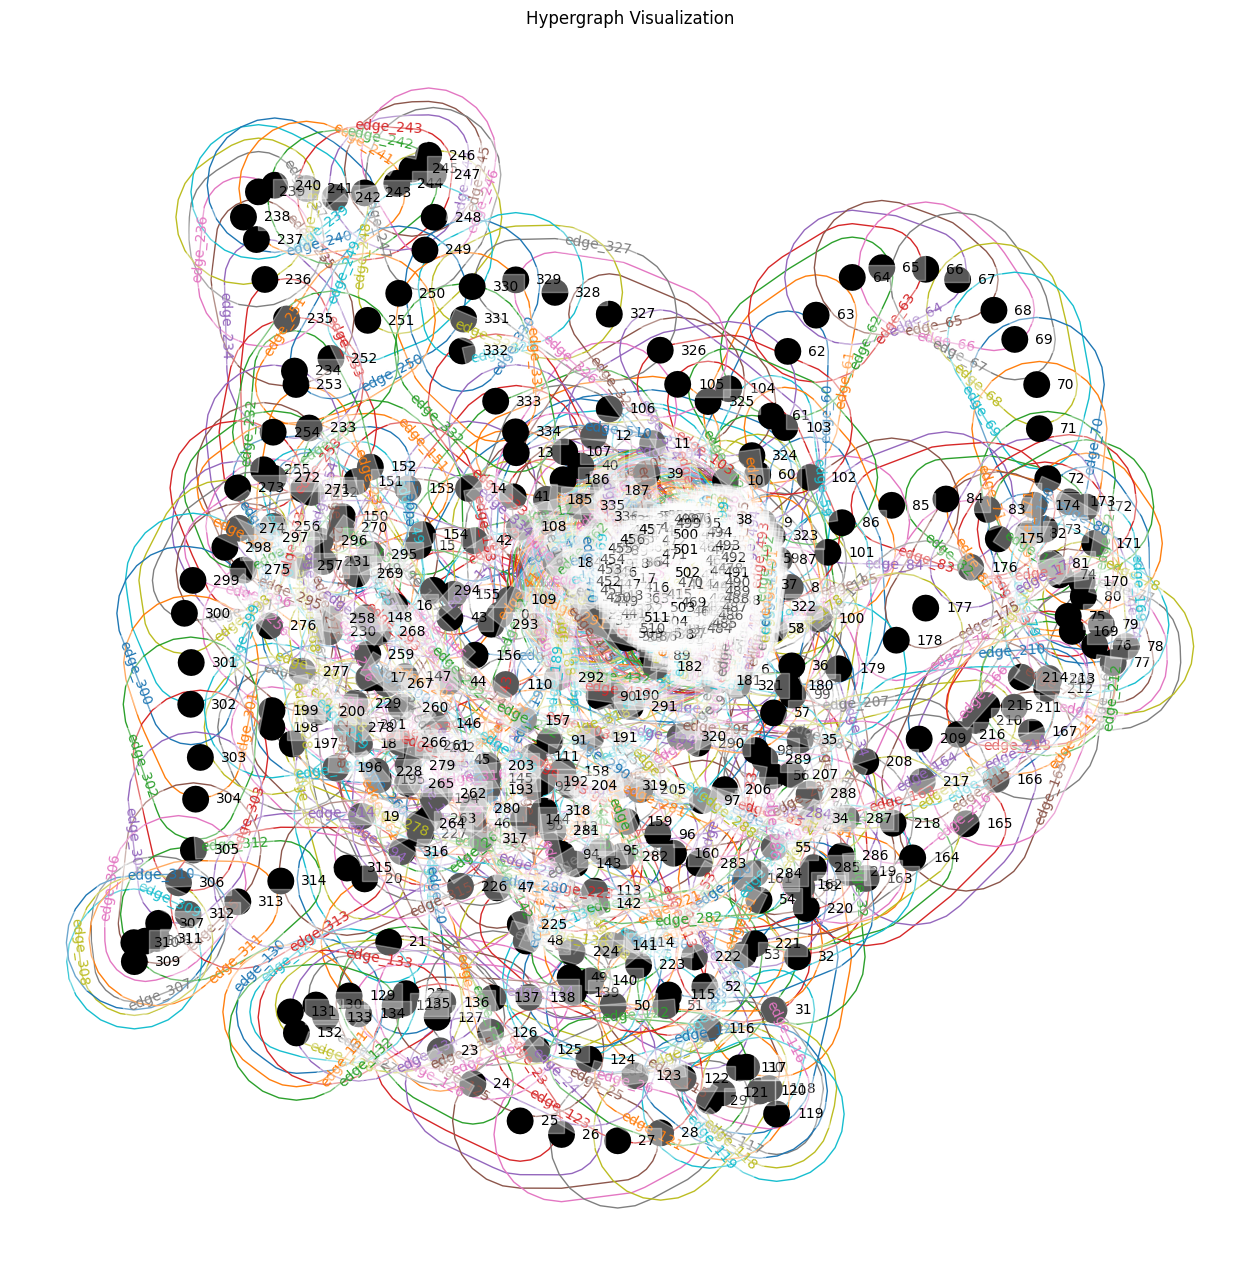

In [ ]:
import hypernetx as hnx
import numpy as np
from hypernetx import draw
import matplotlib.pyplot as plt

# Generate H_matrix for the first example in the dataset
# Assuming 'dataset' and 'tokenizer' are available from previous cells
if 'dataset' in globals() and 'tokenizer' in globals() and len(dataset) > 0:
    first_example = dataset[0]
    context = first_example["context"]
    question = first_example["question"]
    H_matrix, tokens = build_hypergraph(context, question, tokenizer)
else:
    print("Dataset or tokenizer not available, or dataset is empty. Cannot build hypergraph.")
    H_matrix = None
    tokens = None


if H_matrix is not None:
    H_numpy = H_matrix.numpy()#lets make our tensor into a numpy

    edges_dict = {}#i learnt how to draw graphs from dicts only :(
    num_tokens, num_edges = H_numpy.shape
    for edge_id in range(num_edges):
        # Find the token indices that belong to this edge
        nodes_in_edge = np.where(H_numpy[:, edge_id] == 1)[0].tolist()
        if nodes_in_edge: # Only add edges that have nodes
            edges_dict[f"edge_{edge_id}"] = nodes_in_edge


    H = hnx.Hypergraph(edges_dict)

    # Visualize the hypergraph
    plt.figure(figsize=(16, 16))
    draw(H)
    plt.title("Hypergraph Visualization")
    plt.show()
else:
    print("Could not visualize hypergraph due to missing data.")

## Train Hypergraph model

In [ ]:
model = HyperGraphQAModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(1, 7):
    model.train()
    total_loss = 0
    for ex in tqdm(data_list, desc=f"Training (epoch {epoch})"):
        enc = ex["encoding"]
        input_ids = enc["input_ids"].to(device)
        mask = enc["attention_mask"].to(device)
        s_pos = ex["start_positions"].to(device)
        e_pos = ex["end_positions"].to(device)

        # Build hypergraph for each example
        original_example_index = data_list.index(ex)
        context = dataset[original_example_index]["context"]
        question = dataset[original_example_index]["question"]
        H_matrix, _ = build_hypergraph(context, question, tokenizer)
        H_matrix = H_matrix.to(device)

        # Pass H_matrix to the model
        s_logits, e_logits = model(input_ids=input_ids, attention_mask=mask, H_matrix=H_matrix)
        loss_s = F.cross_entropy(s_logits, s_pos.unsqueeze(0))
        loss_e = F.cross_entropy(e_logits, e_pos.unsqueeze(0))
        loss = (loss_s + loss_e) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    em, f1 = evaluate_model(model, data_list, tokenizer, n_sample=50, device=device)
    print(f"Epoch {epoch}: loss={total_loss/len(data_list):.4f}, EM={em:.3f}, F1={f1:.3f}")

# Save the trained model
torch.save(model.state_dict(), "hypergraph_qa_model.pth")
print("Model saved to hypergraph_qa_model.pth")

Training (epoch 1):   0%|                                                                      | 0/400 [00:31<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 3.21 GiB is free. Of the allocated memory 3.47 GiB is allocated by PyTorch, and 176.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def visualize_attention(context, question, model, tokenizer):
    enc = tokenizer(question, context, return_tensors="pt", truncation=True, max_length=128)
    input_ids = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        s_logits, e_logits = model(input_ids, mask)
    s_scores = s_logits[0].cpu().numpy()
    e_scores = e_logits[0].cpu().numpy()
    plt.figure(figsize=(10,4))
    plt.plot(s_scores, label="Start Logits")
    plt.plot(e_scores, label="End Logits")
    plt.legend()
    plt.title("Model Token Confidence (Start/End)")
    plt.show()

first = dataset[0]
visualize_attention(first["context"], first["question"], model, tokenizer)

NameError: name 'model' is not defined

In [ ]:
example = data_list[0]
enc = example["encoding"]
with torch.no_grad():
    s_logits, e_logits = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
s, e = torch.argmax(s_logits), torch.argmax(e_logits)
tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0][s:e+1])
pred_text = tokenizer.convert_tokens_to_string(tokens)
print("Question:", dataset[0]["question"])
print("Predicted:", pred_text)
print("Correct:", example["answer_text"])


NameError: name 'model' is not defined

In [ ]:
!pip install spacy networkx transformers sentencepiece --quiet
!python -m spacy download en_core_web_sm --quiet

import spacy, networkx as nx
from transformers import MarianMTModel, MarianTokenizer

# Load SpaCy model & Translator
nlp = spacy.load("en_core_web_sm")
model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer_fr = MarianTokenizer.from_pretrained(model_name)
model_fr = MarianMTModel.from_pretrained(model_name)

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
# ---- Graph Traversal & Segment Translation ----
def graph_based_translate(sentence: str) -> str:
    if not sentence.strip():
        return ""

    G, doc = build_dependency_graph(sentence)

    # Identify key chunks (subject, verb, object, modifiers)
    segments = []
    for chunk in doc.noun_chunks:
        segments.append(chunk.text)
    verbs = [token.text for token in doc if token.pos_ == "VERB"]
    segments.extend(verbs)
    segments = list(dict.fromkeys(segments))  # deduplicate

    # Translate each segment independently
    translations = []
    for seg in segments:
        batch = tokenizer_fr([seg], return_tensors="pt", padding=True)
        gen = model_fr.generate(**batch, max_length=100)
        fr_text = tokenizer_fr.batch_decode(gen, skip_special_tokens=True)[0]
        translations.append((seg, fr_seg))

    # Reconstruct French answer preserving dependency order
    fr_sentence = sentence
    for seg, fr_seg in translations:
        fr_sentence = fr_sentence.replace(seg, fr_seg)

    # Basic cleanup: capitalize, fix spacing
    fr_sentence = fr_sentence.strip().capitalize()
    return fr_sentence

In [ ]:
# ---- Integrated QA + Graph Translation ----
def qa_graph_translate(question: str, context: str, model, tokenizer, device):
    """
    Run the English QA model, then perform graph-based translation.
    """
    # Use the HyperGraphQAModel to get the English answer
    model.eval()
    with torch.no_grad():
        enc = tokenizer(
            question,
            context,
            truncation=True,
            padding="max_length",
            max_length=512,
            return_tensors="pt",
            return_offsets_mapping=True,
            return_token_type_ids=True # Ensure token type ids are returned for hypergraph
        )
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)

        # Build hypergraph for the example
        H_matrix, _ = build_hypergraph(context, question, tokenizer)
        H_matrix = H_matrix.to(device)

        s_logits, e_logits = model(input_ids=input_ids, attention_mask=attention_mask, H_matrix=H_matrix)

        # Get predicted start and end tokens
        s = torch.argmax(s_logits[0]).item()
        e = torch.argmax(e_logits[0]).item()

        # Extract the English answer from the context using offsets
        offsets = enc["offset_mapping"][0]
        start_char = offsets[s][0].item()
        end_char = offsets[e][1].item()
        answer_en = context[start_char:end_char]


    answer_fr = graph_based_translate(answer_en)

    print("🧠 English Answer:", answer_en)
    print("🌐 Graph-based French Translation:", answer_fr)
    return {"answer_en": answer_en, "answer_fr": answer_fr}

# ---- DEMO ----
sample_q = "Who announced the new climate agreement yesterday?"
sample_context = """
UN Secretary-General Antonio Guterres announced a new climate agreement at the UN Headquarters in New York yesterday.
"""
# You need to pass the model, tokenizer, and device to the function
# Assuming 'model', 'tokenizer', and 'device' are defined in previous cells
qa_graph_translate(sample_q, sample_context, model, tokenizer, device)

NameError: name 'model' is not defined

# Task
Add cells to the notebook that explain and implement cross-attention in the `HyperGraphQAModel` for question answering, discuss the connection to French bipartite graphs, and demonstrate how to use the updated model with the `qa_graph_translate` function.

## Understand the concepts

### Subtask:
Briefly explain what cross-attention in transformers is and how it could be applied in a QA setting with hypergraphs. Also, explain what a bipartite graph is and how it relates to a hypergraph.


**Reasoning**:
Create a markdown cell to explain cross-attention, bipartite graphs, and their relevance to the HyperGraphQAModel and hypergraphs, as requested by the subtask.



In [32]:
## Cross-Attention and Bipartite Graphs in QA

### Cross-Attention in Transformers

Cross-attention is a mechanism in transformer models that allows a sequence to attend to a different sequence. In the context of Question Answering (QA), cross-attention is typically used to enable the model to focus on relevant parts of the *context* sequence while processing the *question* sequence, and vice versa. This is crucial for understanding the relationship between the question and the context and identifying the span of the answer within the context. The query comes from one sequence (e.g., the question), and the key and value come from the other sequence (e.g., the context).

### Cross-Attention with Hypergraphs in QA

In the `HyperGraphQAModel`, after the initial token embeddings are processed through the BERT encoder and potentially enhanced by the hypergraph layers (HyperGCN), cross-attention could be applied. This would allow the model to refine the token representations by considering the interaction between the question tokens and the context tokens, taking into account the relationships captured by the hypergraph structure. Specifically, after the hypergraph layers have aggregated information based on local (window-based) and global (question-based) hyperedges, a cross-attention mechanism could allow the model to:

1.  **Question-to-Context Attention:** Attend to the context tokens based on the question tokens' representations, helping to pinpoint the potential answer span.
2.  **Context-to-Question Attention:** Attend to the question tokens based on the context tokens' representations, helping to understand the type of information being asked for.

This integration of hypergraph processing and cross-attention could lead to a more nuanced understanding of the question-context relationship and potentially improve answer extraction.

### Bipartite Graphs and Hypergraphs

A **bipartite graph** is a graph whose vertices can be divided into two disjoint and independent sets, U and V, such that every edge connects a vertex in U to one in V. There are no edges within U or within V.

A **hypergraph** can be represented as a bipartite graph. In this representation, one set of vertices (U) corresponds to the original nodes of the hypergraph (e.g., tokens), and the other set of vertices (V) corresponds to the hyperedges. An edge exists between a node in U and a node in V if and only if the original node is a member of the corresponding hyperedge in the hypergraph. This bipartite representation is often called the **incidence graph** of the hypergraph. The incidence matrix of a hypergraph is essentially the adjacency matrix of its bipartite representation. This connection highlights that the hypergraph structure, which allows relationships between more than two nodes simultaneously, can be understood and analyzed through the framework of bipartite graphs.

SyntaxError: unterminated string literal (detected at line 11) (4147048049.py, line 11)